# Второе домашнее задание 
— самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются. 
Третье задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. 

Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;

* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.


## Загрузка данных

In [1]:
import os
import pandas as pd
import pickle

In [2]:
os.listdir('chgk')

['players.pkl', 'results.pkl', 'tournaments.pkl']

In [3]:
with open('chgk/results.pkl', 'rb') as f:
    results_raw = pickle.load(f)
    
with open('chgk/tournaments.pkl', 'rb') as f:
    tournaments_raw = pickle.load(f)
    
with open('chgk/players.pkl', 'rb') as f:
    players_raw = pickle.load(f)

Результаты

In [4]:
results_dataframes = {k: pd.DataFrame(v) for k, v in results_raw.items()}

results = []
for k, df in results_dataframes.items():
    df['tournament_id'] = k
    results.append(df)
results = pd.concat(results, axis=0, ignore_index=True)
results.dropna(subset=['mask'], inplace=True)

In [5]:
results.head()

,team,mask,current,questionsTotal,synchRequest,position,controversials,flags,teamMembers,tournament_id
2407,"{'id': 1, 'name': 'Неспроста', 'town': {'id': ...",0111011101101110001101110011111111110011111100...,"{'name': 'КП - Неспроста', 'town': {'id': 201,...",67.0,None,1.0,[],[],"[{'flag': None, 'usedRating': 0, 'rating': 0, ...",22
2408,"{'id': 2, 'name': 'Афина', 'town': {'id': 201,...",0111111101011010010101110111111111110011011111...,"{'name': 'Афина', 'town': {'id': 201, 'name': ...",65.0,None,2.5,[],[],"[{'flag': None, 'usedRating': 0, 'rating': 0, ...",22
2409,"{'id': 670, 'name': 'Ксеп', 'town': {'id': 201...",0011111101011010011101110011111111110111111111...,"{'name': 'Ксеп', 'town': {'id': 201, 'name': '...",65.0,None,2.5,[],[],"[{'flag': None, 'usedRating': 0, 'rating': 0, ...",22
2410,"{'id': 173, 'name': 'ЮМА', 'town': {'id': 285,...",0111111001101110001101111011111111110100111111...,"{'name': 'ЮМА-Энергокапитал', 'town': {'id': 2...",64.0,None,4.5,[],[],"[{'flag': None, 'usedRating': 0, 'rating': 0, ...",22
2411,"{'id': 175, 'name': 'Транссфера', 'town': {'id...",0111111001101111001111111011111110110010111110...,"{'name': 'Транссфера', 'town': {'id': 285, 'na...",64.0,None,4.5,[],[],[],22


In [6]:
results.sample(1)

,team,mask,current,questionsTotal,synchRequest,position,controversials,flags,teamMembers,tournament_id
247405,"{'id': 53963, 'name': 'Случайные Люди', 'town'...",011101001010011110110101000000000000,"{'name': 'Случайные Люди', 'town': {'id': 344,...",14.0,None,488.0,[],[],"[{'flag': 'Л', 'usedRating': 0, 'rating': 3421...",3708


In [7]:
# посмотрим как выглядят примеры записей в таблице

results.loc[166992, 'current'], results.loc[166992, 'team'], results.loc[166992, 'teamMembers'], results.loc[166992, 'synchRequest']

({'name': 'Южный Парк', 'town': {'id': 236, 'name': 'Одесса'}},
 {'id': 4777, 'name': 'Южный Парк', 'town': {'id': 236, 'name': 'Одесса'}},
 [{'flag': 'К',
   'usedRating': 4598,
   'rating': 4602,
   'player': {'id': 26243,
    'name': 'Николай',
    'patronymic': 'Алексеевич',
    'surname': 'Пручковский'}},
  {'flag': 'Б',
   'usedRating': 3612,
   'rating': 4337,
   'player': {'id': 35920,
    'name': 'Владимир',
    'patronymic': 'Викторович',
    'surname': 'Шевчук-Иркмаан'}},
  {'flag': 'Б',
   'usedRating': 2771,
   'rating': 4160,
   'player': {'id': 67902,
    'name': 'Дмитрий',
    'patronymic': 'Леонидович',
    'surname': 'Адамовский'}},
  {'flag': 'Л',
   'usedRating': 1791,
   'rating': 3584,
   'player': {'id': 96079,
    'name': 'Ирина',
    'patronymic': 'Вячеславовна',
    'surname': 'Горавская'}}],
 {'id': 10653, 'venue': {'id': 3134, 'name': 'Одесса'}})

In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441410 entries, 2407 to 528742
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   team            441410 non-null  object 
 1   mask            441410 non-null  object 
 2   current         441410 non-null  object 
 3   questionsTotal  441410 non-null  float64
 4   synchRequest    319488 non-null  object 
 5   position        441410 non-null  float64
 6   controversials  441410 non-null  object 
 7   flags           441410 non-null  object 
 8   teamMembers     441410 non-null  object 
 9   tournament_id   441410 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 53.2+ MB


Турниры

In [9]:
tournaments = pd.DataFrame.from_dict(tournaments_raw, orient='index')
tournaments['dateStart'] = tournaments['dateStart'].str[:-6]  # remove timezones coz it's not so important here
tournaments['dateEnd'] = tournaments['dateEnd'].str[:-6]

tournaments['dateStart'] = pd.to_datetime(tournaments['dateStart'], format='%Y-%m-%d %H:%M:%S')
tournaments['dateEnd'] = pd.to_datetime(tournaments['dateEnd'], format='%Y-%m-%d %H:%M:%S')

tournaments.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25,2003-07-27,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09,2003-08-09,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22,2003-11-24,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11,2003-10-12,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10,2003-10-13,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [10]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 1 to 6485
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            5528 non-null   int64         
 1   name          5528 non-null   object        
 2   dateStart     5528 non-null   datetime64[ns]
 3   dateEnd       5528 non-null   datetime64[ns]
 4   type          5528 non-null   object        
 5   season        5434 non-null   object        
 6   orgcommittee  5528 non-null   object        
 7   synchData     1855 non-null   object        
 8   questionQty   4343 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 431.9+ KB


In [11]:
train_test_tournaments = tournaments[tournaments['dateStart'].dt.year.isin([2019, 2020])]

Игроки

In [12]:
players = pd.DataFrame.from_dict(players_raw, orient='index')
players.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [13]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204063 entries, 1 to 224704
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          204063 non-null  int64 
 1   name        204063 non-null  object
 2   patronymic  204032 non-null  object
 3   surname     204063 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.8+ MB


## Преобразуем результаты в повопросные результаты для каждого игрока

In [14]:
print(results.shape)
results = results[results['tournament_id'].isin(train_test_tournaments['id'])]
print(results.shape)


(441410, 10)
(108894, 10)


In [15]:
# filter results of tournaments in 2019, 2020 only
results = results[results['tournament_id'].isin(train_test_tournaments['id'])]

# construct player_results DataFrame for each player
results['number_of_players'] = results['teamMembers'].apply(lambda team: len(team))
results['team'] = results['team'].apply(lambda x: x['id'])
results = results[results['number_of_players'] > 0]
count = results['number_of_players']  # the trick below used for transform we use at work, hope it will be clear
count = count.repeat(count.max())
count.index = count.index.rename('old_index')
count = count.reset_index()
count['count'] = count.groupby('old_index').cumcount()
count = count[count['count'] < count['number_of_players']].drop(['number_of_players'], axis=1)
count.set_index('old_index', inplace=True)

player_results = results.join(count)
player_results['count'] = player_results['count'].astype('int')
player_results['player'] = player_results.apply(lambda row: row['teamMembers'][row['count']], axis=1)
player_results = pd.concat([
    player_results.drop(['player'], axis=1).reset_index(drop=True), 
    pd.DataFrame(player_results['player'].tolist())
], axis=1)
player_results['player'] = player_results['player'].apply(lambda x: x['id'])
player_results.drop(['count', 'current', 'synchRequest', 'controversials', 'flag', 'flags', 'teamMembers'], axis=1, inplace=True)

In [16]:
player_results.head()

,team,mask,questionsTotal,position,tournament_id,number_of_players,usedRating,rating,player
0,45556,111111111011111110111111111100010010,28.0,1.0,4772,6,13507,13507,6212
1,45556,111111111011111110111111111100010010,28.0,1.0,4772,6,10988,13185,18332
2,45556,111111111011111110111111111100010010,28.0,1.0,4772,6,8534,12801,18036
3,45556,111111111011111110111111111100010010,28.0,1.0,4772,6,6401,12801,22799
4,45556,111111111011111110111111111100010010,28.0,1.0,4772,6,4252,12757,15456


In [17]:
# construct player_results DataFrame for each question
# drop columns that are not required to decrease amount of memory used 

player_results['questions_count'] = player_results['mask'].apply(lambda x: len(x))
player_results = player_results[player_results['questions_count'] > 0]
count = player_results['questions_count']
count = count.repeat(count.max())
count.index = count.index.rename('old_index')
count = count.reset_index()
count['count'] = count.groupby('old_index').cumcount()
count = count[count['count'] < count['questions_count']].drop(['questions_count'], axis=1)
count.set_index('old_index', inplace=True)

question_results = player_results.join(count)
question_results['count'] = question_results['count'].astype('int')
question_results['result'] = question_results.apply(lambda row: row['mask'][row['count']], axis=1)

tournament_id + count - уникальный ключ каждого вопроса

In [18]:
train_tournaments = tournaments[tournaments['dateStart'].dt.year == 2019]
test_tournaments = tournaments[tournaments['dateStart'].dt.year == 2020]

train = question_results[question_results['tournament_id'].isin(train_tournaments['id'])]
test = question_results[question_results['tournament_id'].isin(test_tournaments['id'])]

In [19]:
set(train['tournament_id']) & set(test['tournament_id'])

set()

In [20]:
len(set(train['player']) & set(test['player'])), len(set(train['player']))

(24614, 59101)

турниры не просочинились между годами - это хорошо.

# Baseline models 

Построим разреженную матрицу для вопросов и игроков, таргетом в которой будет булева величина - ответил игрок на вопрос или нет. 

In [21]:
train = train[train['result'].isin(['1', '0'])]
X_train = train[['tournament_id', 'player', 'count']]
y_train = train['result'].astype('int')

X_train, y_train

(        tournament_id  player  count
 0                4772    6212      0
 0                4772    6212      1
 0                4772    6212      2
 0                4772    6212      3
 0                4772    6212      4
 ...               ...     ...    ...
 552093           6255  217156     31
 552093           6255  217156     32
 552093           6255  217156     33
 552093           6255  217156     34
 552093           6255  217156     35
 
 [20910740 rows x 3 columns],
 0         1
 0         1
 0         1
 0         1
 0         1
          ..
 552093    0
 552093    0
 552093    0
 552093    0
 552093    0
 Name: result, Length: 20910740, dtype: int32)

Закодируем вопросы и игроков с помощью OneHotEncoder

In [22]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np

encoder_questions = OneHotEncoder(handle_unknown='ignore')
encoder_players = OneHotEncoder(handle_unknown='ignore')

questions_ohe = encoder_questions.fit_transform(X_train[['tournament_id', 'count']])
players_ohe = encoder_players.fit_transform(X_train[['player']])

X_train = hstack((questions_ohe, players_ohe))
X_train.shape

(20910740, 60276)

In [23]:
from sklearn.linear_model import LogisticRegression
import pickle

TRAIN = False

baseline = LogisticRegression(max_iter=10000, n_jobs=-1)
if TRAIN:
    baseline.fit(X_train, y_train)
    with open('baseline.pickle', 'wb') as bf:
        pickle.dump(baseline, bf)
else:
    with open('baseline.pickle', 'rb') as bf:
        baseline = pickle.load(bf)

In [24]:
baseline_coef = baseline.coef_
baseline_coef


array([[-0.06388741,  0.22368074,  0.19378416, ..., -0.48092035,
         0.75531412,  1.17225604]])

## Ранжируем команды

Задача построить DF с колонками team, tournament -> position для тестирования модели.

Будем использовать коэффициенты линейной регресии, для ранжирования команды. Можно попробовать ставить в соответствие команде:
* максимальный коэффициент
* средний коэффициент участников

Затем ранжировать команды по этому коэффициенту.

Хотя коэффициенты линейной регрессии могут для разных игроков быть разных порядков. Предполагаю, что для игроков одного класса они будут близки, поскольку они отвечают на вопросы одинаковой сложности.

In [25]:
players_coef = baseline_coef[questions_ohe.shape[1]:]

test = test[test['result'].isin(['1', '0'])]
y_test = test['result'].astype(int)
X_test = encoder_players.transform(test[['player']])

y_test.shape, X_test.shape, players_coef.shape

((4469664,), (4469664, 59101), (0, 60276))

In [26]:
test['player_coef'] = pd.Series((X_test @ baseline_coef[:, questions_ohe.shape[1]:].T)[:, 0])
test.sample(5)

,team,mask,questionsTotal,position,tournament_id,number_of_players,usedRating,rating,player,questions_count,count,result,player_coef
483323,54699,0110000010X0011010000000101000000000,8.0,342.0,6041,5,1734,3467,114800,36,33,0,0.000000
497919,5170,111110001011111111000101111101011111101001110111,34.0,69.5,6093,6,1465,8787,20864,48,1,1,0.539372
553182,70958,010100000000000000000000001010000000,4.0,25.5,6260,6,1926,3851,176533,36,20,0,0.687397
512643,67745,110110000011010100010001100011110011,17.0,285.0,6172,2,6560,7872,219893,36,14,0,0.133135
558798,77728,000100001100011101100000000100001010,11.0,113.0,6295,6,0,0,223537,36,11,0,1.079423


Подход к ранжированию через максимум

In [27]:
agg_test_max = test.groupby(['team', 'tournament_id', 'position']).agg({'player_coef': 'max'})
agg_test_max.sort_values(by='player_coef', ascending=False, inplace=True)
agg_test_max['prediction'] = agg_test_max.groupby('tournament_id')['player_coef'].cumcount()
agg_test_max['prediction'] = agg_test_max.groupby(['tournament_id', 'player_coef']).transform('mean')
agg_test_max.reset_index(inplace=True)

In [28]:
from scipy.stats import spearmanr, kendalltau

x = agg_test_max['position']
y = agg_test_max['prediction']

# Расчет статистики Спирмена
corr_spearman, p_value = spearmanr(x, y)
print("Коэффициент Спирмена:", corr_spearman)
print("p-значение:", p_value)

# Расчет статистики Кендалла
corr_kendall, p_value = kendalltau(x, y)
print("Коэффициент Кендалла:", corr_kendall)
print("p-значение:", p_value)


Коэффициент Спирмена: 0.634417540219356
p-значение: 0.0
Коэффициент Кендалла: 0.46372162974487974
p-значение: 0.0


Подход к ранжированию через минимум

In [102]:
agg_test_mean = test.groupby(['team', 'tournament_id', 'position']).agg({'player_coef': 'mean'})
agg_test_mean.sort_values(by='player_coef', ascending=False, inplace=True)
agg_test_mean['prediction'] = agg_test_mean.groupby('tournament_id')['player_coef'].cumcount()
agg_test_mean['prediction'] = agg_test_mean.groupby(['tournament_id', 'player_coef'])['prediction'].transform('mean')
agg_test_mean.reset_index(inplace=True)

In [30]:
from scipy.stats import spearmanr, kendalltau

x = agg_test_mean['position']
y = agg_test_mean['prediction']

# Расчет статистики Спирмена
corr_spearman, p_value = spearmanr(x, y)
print("Коэффициент Спирмена:", corr_spearman)
print("p-значение:", p_value)

# Расчет статистики Кендалла
corr_kendall, p_value = kendalltau(x, y)
print("Коэффициент Кендалла:", corr_kendall)
print("p-значение:", p_value)


Коэффициент Спирмена: 0.6329788525458869
p-значение: 0.0
Коэффициент Кендалла: 0.4625501643006748
p-значение: 0.0


# EM алгоритм

In [31]:
X_train

<20910740x60276 sparse matrix of type '<class 'numpy.float64'>'
	with 62732220 stored elements in Compressed Sparse Row format>

In [32]:
!pip show scipy

Name: scipy
Version: 1.8.0
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: 
Author-email: 
License: BSD
Location: c:\dpm\py_env\lib\site-packages
Requires: numpy
Required-by: arviz, catboost, filterpy, mapclassify, plotly-express, scikit-learn, seaborn, shap, statsmodels


In [33]:
from scipy.sparse import coo_matrix

In [34]:
from scipy.sparse import coo_array
import torch 

X_train = coo_array(X_train)

indices = np.vstack((X_train.row, X_train.col))

X_train_torch = torch.sparse.FloatTensor(
    torch.LongTensor(indices), 
    torch.FloatTensor(X_train.data), 
    torch.Size(X_train.shape)
)

y_train_torch = torch.from_numpy(y_train.values)

In [106]:
import torch.nn as nn
from torch.optim import Adam
from IPython import display
import matplotlib.pyplot as plt

def EM_algorithm():
    plot_frequancy = 2
    input_size = X_train_torch.shape[1]
    model = nn.Linear(input_size, 1)
    opt = Adam(model.parameters(), lr=0.1)
    loss = nn.BCELoss()
    n_iter = 20
    n_players = len(encoder_players.categories_[0])
    
    val_loss_history = []
    for i in range(n_iter):
        y_pred = e_step(model, X_train_torch, y_train_torch)  # y_true scaled with prod of probability to answer
        m_step(model, opt, loss, X_train_torch, y_pred)

        if i % plot_frequancy == 0:
            test_data['player_coef'] = pd.Series((X_test @ model.weight.data.flatten()[questions_ohe.shape[1]:].reshape(-1, 1))[:, 0])
            
            agg_test_mean = test_data.groupby(['team', 'tournament_id', 'position']).agg({'player_coef': 'mean'})
            agg_test_mean.sort_values(by='player_coef', ascending=False, inplace=True)
            agg_test_mean['prediction'] = agg_test_mean.groupby('tournament_id')['player_coef'].cumcount()
            agg_test_mean['prediction'] = agg_test_mean.groupby(['tournament_id', 'player_coef'])['prediction'].transform('mean')
            agg_test_mean.reset_index(inplace=True)
            
            # raplace with global spearman calc
            spearman_corr = spearmanr(agg_test_mean['position'], agg_test_mean['prediction']).correlation
            val_loss_history.append(spearman_corr)

            display.clear_output(wait=True)
            print(f'num epoch - {i}')
            print(f'Spearman correlation {spearman_corr:.3f}')
            plt.ylim(0, 1)
            plt.xlim(0, n_iter)
            plt.plot(range(len(val_loss_history)), val_loss_history)
            plt.show()
            
def e_step(model, X, y_true):
    model.eval()
    with torch.no_grad():
        out = model(X).flatten()
        y_pred = torch.sigmoid(out)
        
    train_data['neg_prob'] = 1 - y_pred.numpy()
    team_neg_prob = train_data.groupby(['team', 'tournament_id', 'count']).agg({'neg_prob': 'prod'})
    team_neg_prob = 1 - train_data[['team', 'tournament_id', 'count']].merge(team_neg_prob.reset_index())['neg_prob']
    return torch.from_numpy((y_true * (y_pred / team_neg_prob)).values).type(torch.FloatTensor)
                            
def m_step(model, opt, loss, X, y):
    model.train()
    opt.zero_grad()

    out = model(X).flatten()
    loss = loss(torch.sigmoid(out), y)

    loss.backward()
    opt.step()
    

num epoch - 18
Spearman correlation 0.603


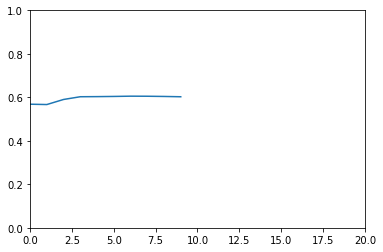

In [107]:
train_data = train[['team', 'player', 'tournament_id', 'count']]
test_data = test[['team', 'player', 'tournament_id', 'count', 'position']]

EM_algorithm()